In [1]:
!pip install mpld3

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline
import mpld3
mpld3.enable_notebook()
import json


In [3]:
PROJECT_ROOT_DIR=Path("../../../").resolve()
assert PROJECT_ROOT_DIR.exists()
DATA_PATH = PROJECT_ROOT_DIR / 'data'
assert DATA_PATH.exists()
DATA_PATH_STRING = str(DATA_PATH)

In [4]:
# you need to compile the project with -DAARE_PYTHON_BINDINGS="ON"
sys.path.append(str((PROJECT_ROOT_DIR / 'build').resolve()))
# check if _aare can be imported
import importlib.util
_aare_module = importlib.util.find_spec("_aare")
assert _aare_module is not None


# File

In [5]:
from _aare import File

In [6]:
# eiger json master file
file = File(DATA_PATH_STRING + "/eiger/eiger_500k_32bit_master_0.json")
print(file.rows,file.cols,file.bitdepth)
print(file.detector_type)
print(file.total_frames)
print("geometry",file.geometry)

512 1024 32
DetectorType.Eiger
3
geometry <xy: row=2, col=2>


In [7]:
from _aare import DetectorType
list(DetectorType.__entries) # DetectorType is an enum

['Jungfrau', 'Eiger', 'Mythen3', 'Moench', 'ChipTestBoard', 'Unknown']

In [8]:
# Frame class

In [9]:
frame = file.read() # read frame from current position
frame

In [10]:
frame.rows,frame.cols,frame.bitdepth,frame.size

(512, 1024, 32, 2097152)

In [11]:
np.array(frame) # create numpy array from frame

array([[915, 906, 857, ..., 736, 721, 830],
       [465, 453, 426, ..., 324, 359, 409],
       [417, 394, 432, ..., 316, 336, 383],
       ...,
       [415, 409, 366, ..., 369, 366, 403],
       [391, 355, 389, ..., 369, 397, 422],
       [398, 374, 409, ..., 425, 376, 427]], dtype=uint32)

In [12]:
np.array(frame,copy=False) # create numpy array from frame without copying data

array([[915, 906, 857, ..., 736, 721, 830],
       [465, 453, 426, ..., 324, 359, 409],
       [417, 394, 432, ..., 316, 336, 383],
       ...,
       [415, 409, 366, ..., 369, 366, 403],
       [391, 355, 389, ..., 369, 397, 422],
       [398, 374, 409, ..., 425, 376, 427]], dtype=uint32)

In [13]:
file.iread(1) # read frame at index 1 (only complete frames are returned)
pos = file.tell() # get the index file is currently pointed to
print("pos",pos)
file.seek(0) # go to index 0
file.read(3) # read three frames. returns list of frames
# file.write(file.iread(0))

pos 1


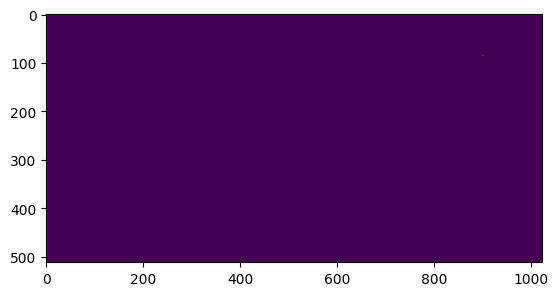

In [14]:
# plot frame
plt.imshow(np.array(frame))
plt.show()

# ClusterFile

the new ClusterFile uses this format:

===Header===

in TEXT format:
   - magic_string: 4 characters ("CLST")
   - header_length: 5 characters (max 99999, must be prefixed with zeros if less than 5 digits
(00123))

in JSON format:
    - version: "0.1" (string max 3 chars)
    - n_records (9 character string doesn't exceed 4*10^9 unsigned should be padded with zeroes
      if less than 10 digits)
    - metadata: metadata (json string max 2^16 chars. no nested json objects, only key-value
      pairs of strings)
    - header_fields (array of field objects):
        - field_label: field_label_length bytes (string max 256 chars)
        - dtype: 3 chars (string)
        - is_array: (number) 0: not array, 1:fixed_length_array, 2:variable_length_array
        - array_length: (number max 2^32) (used if is_array == 1)

        if field is:
           - not array: value of the field (dtype.bytes())
           - fixed_length_array: array_length * dtype.bytes()
           - variable_length_array: 4 bytes (number of elements) + number_of_elements *
dtype.bytes()

    - data_fields (array of field objects):
        - field_label: field_label_length bytes (string max 256 chars)
        - dtype: 3 chars (string)
        - is_array: (number) 0: not array, 1:fixed_length_array, 2:variable_length_array
        - array_length: (number max 2^32) (used if is_array == 1)


===DATA===

in Binary format:

data:
    - header fields
    - data fields
    - header fields
    - data fields
    ...

**Note:**  
ClusterFile is very flexible it can work with different types of clusters. its implementation can be found in c++ code.

In python bindings it is exposed only to use ClusterHeader and Cluster classes
- ClusterHeader containts two int32 frame_number and n_clusters
- Cluster contains two int16 x,y and 9 element array of type int32 called data

other types of clusters (variable length, templated...) exist in C++ code but they are not exposed in python.


In [15]:
from _aare import ClusterFile, ClusterFileHeader, ClusterHeader,Cluster, OldCluster, Field, Dtype

In [16]:
field = Field() # describes the type,size of a field in the clusterFile 
# example: x or y fields of a cluster can be {"label":"x","dtype":"<i2", "is_array":0} to say it is a int16 and not an array
field.label="x" # label for this field
field.dtype = Dtype("<i2") # data type
field.is_array = 0 # single value? fixed length array? variable length array?
field.to_json() # convert to JSON String

'{"label": "x", "dtype": "<i2", "is_array": 0, "array_size": 0}'

In [17]:
cluster_file_header = ClusterFileHeader() # Contains the header of the ClusterFile
cluster_file_header.version # string containts the version of the ClusterFile 
cluster_file_header.metadata # dict containing comments about the file
cluster_file_header.n_records # number containing the number of records in the file
cluster_file_header.header_fields # contains a list of Fields describing the cluster header
cluster_file_header.data_fields # contains a list of Fields describing the cluster data


[]

In [18]:
cluster_header = ClusterHeader() # ClusterHeader is used to hold the header 
cluster_header.frame_number = 9
cluster_header.n_clusters = 100
cluster_header

frame_number: 9 n_clusters: 100

In [26]:
cluster = Cluster(9,Dtype("f8"))
cluster.x = 2
cluster.y =8
print(cluster.count)
# np.array(cluster.data() copy=False)[8]=199
arr=np.array(cluster.data(),copy=False)
np.array(cluster.data(),np.float64)

9


array([107., 239., 233.,  85.,  21.,  86.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.])

In [ ]:
old_cluster_file_header = ClusterFileHeader()
old_cluster_file_header.header_fields = ClusterHeader.get_fields()
old_cluster_file_header.data_fields = OldCluster.get_fields()
header_json = old_cluster_file_header.to_json()
print(json.dumps(json.loads(header_json), indent=4))

In [ ]:
fpath =DATA_PATH_STRING + "/clusters/beam_En700eV_-40deg_300V_10us_d0_f0_100.clust"
file = ClusterFile(fpath,"r", old_cluster_file_header,True)
file

In [ ]:
header,clusters = file.read() # returns a header and clusters
print(header)
len(clusters)

In [ ]:
file.frame_number() # get the frame number where clusterFile currently points to

In [ ]:
clusters = file.read()
len(clusters)

In [ ]:
cluster = clusters[0]
print(cluster.frame_number, cluster.cluster.x,cluster.cluster.y) # get cluster information
np.array(cluster.cluster.data,np.int32) # view cluster data 

# Pedestal

In [ ]:
from _aare import Pedestal
file = File("/mnt/sls_det_storage/moench_data/testNewFW20230714/cu_half_speed_master_4.json")
file.rows,file.cols,file.detector_type

In [ ]:
pedestal = Pedestal(file.rows,file.cols)
pedestal.rows,pedestal.cols,pedestal.n_samples

In [ ]:
ndarray = pedestal.mean() # pedestal mean returns an internal NDArray object of type float8 and dimensions 2
ndarray

In [ ]:
np.array(ndarray) # to convert NDArray to numpy array with copying the data
np.array(ndarray,copy=False) # to convert NDArray to numpy array without copying the data


In [ ]:
ndarray.shape,ndarray.size,ndarray.bitdepth,ndarray.strides,ndarray.byte_strides

In [ ]:
ndarray[0,300]

In [ ]:
for i in range(2000):
    frame = file.iread(i)
    pedestal.push(frame) # push 2000 frames into the pedestal
    

In [ ]:
mean = np.array(pedestal.mean())
plt.imshow(mean)
plt.show()


In [ ]:
frame=file.iread(3000) # read frame at index 3000
plt.imshow(frame.array())
plt.title("Frame")
plt.show()

In [ ]:
frame=file.iread(3000) # read frame at index 3000
denoised_frame = frame.array()-pedestal.mean()
plt.imshow(denoised_frame)
plt.title("denoised frame")
plt.show()

In [ ]:
#other utilities in pedestal
pedestal.variance() # get NDArray of the variance for each pixel 
pedestal.standard_deviation() # get NDArray of the standard deviation for each pixel 
pedestal.sum # get NDArray of the sum squared for each pixel 
pedestal.sum2 # get NDArray of the sum squared for each pixel 
pedestal.clear() # resets the pedestal
# mean, variance, standard_deviation and clear can accept indexes to apply only specific pixels
row,col=0,0
pedestal.mean(row,col)
pedestal.variance(row,col)
pedestal.standard_deviation(row,col)
pedestal.clear(row,col)

# ClusterFinder

In [ ]:
from _aare import ClusterFinder

In [ ]:
cf = ClusterFinder(3,3,1.0,1) # cluster_sizeX, cluster_sizeY, nSigma, threshold (can be ignored depending on the function called later)

In [ ]:
clusters = cf.find_clusters_without_threshold(denoised_frame,pedestal)
len(clusters)

In [ ]:
# x_arr,y_arr=[],[]
# for cluster in clusters:
#     denoised_frame[cluster.x,cluster.y]=-1000
# plt.imshow(denoised_frame)
# plt.show()